# Description of the Algorithm

As described on Wikipedia(https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) steps:

1. Scale-Space Extrema Detection
2. Keypoint Localization
3. Orentation Assignment
4. Local Descriptor Creation

# Scale-Space Extrema Detection

## 1.1 Laplacian-of-Gaussian (LoG) filter

The characteristic scale of a feature can be detected using a scale-normalized Laplacian-of-Gaussian (LoG) filter. The LoG filter is highly peaked at the center while becoming slightly negative and then zero at a distance from the center characterized by the standard deviation, sigma, of the Gaussian.

![alt text](https://i.stack.imgur.com/PuyZi.png)
![alt text](https://i.stack.imgur.com/u8I01.png)

Therefore, the LoG filter is most highly activated by a circle, or blob, with radius proportional to sigma. However, the Gaussian is normalized, i.e. if you integrate it over all space it sums to one. Therefore, with a higher sigma and therefore a wider Gaussian, the response of the LoG filter for that Gaussian will be lower than for a smaller sigma. Therefore, SIFT uses the scale-normalized LoG filter which is the regular LoG multiplied by the variance (sigma squared).

### 1.2 DoG Approximation

![alt text](https://miro.medium.com/max/625/1*jFQVYG7VrXs44V0Qbr1GUQ.gif)

## 1.3 DoG pyramid

Now that we have an efficient way to approximate the LoG, we need to compute it at multiple scales. SIFT uses a number of *octaves* to calculate the DoG. Most people would think that an octave means that eight images are computed. However, an octave is actually a set of images were the blur of the last image is **double** the blur of the first image.

To create this octave, we first need to choose the number of images we want in each octave. This is denoted by $s$. Then the sigma for the Gaussian filter is chosen to be $2^{(1/s)}$. Since blur accumulates multiplicatively, when we blur the original image with this filter $s$ times, the result will have *blur* = 2 * *original blur*.

One detail from the paper that I rarely see mentioned is that in each octave, you actually need to produce $s+3$ images (including the original image). This is because when adjacent levels are subtracted to obtain the approximated LoG octave, we will get one less image than in the Gaussian octave:

![alt text](https://miro.medium.com/max/1206/1*vzUvEVlZWbfCDBO44fIdcw.png)

Now we have $s+2$ images in the DoG octave. However, later when we look for extrema in the DoG, we will look for the min or max of a neighborhood specified by the current and adjacent levels. Obviously, this neighborhood cannot be obtained at the top or bottom level, so we have these two extra levels so that the neighborhood is defined over a full octave in the scale space. This will be more clear in the next section.

After we have generated the Gaussian octave, we downsample the top level by two and use that as the bottom level for a new octave. The original paper uses four octaves. These octaves make up what I call the Gaussian pyramid.

## 1.4 Gaussian filter

We need a Gaussian filter for creation of the Gaussian octave.

In [1]:
import numpy as np

def gaussian_filter(sigma):
  size = 2*np.ceil(3*sigma)+1
  x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
  g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
  return g/g.sum()

print('Definition of gaussian_filter()')

Definition of gaussian_filter()


## 1.5 Generation of Gaussian Octave

We need to select sigma (or $k$ as it is called in the paper) and repeatedly convolve with the Gaussian filter:

In [2]:
from scipy.ndimage.filters import convolve

def generate_octave(init_level, s, sigma):
  octave = [init_level]
  k = 2**(1/s)
  kernel = gaussian_filter(k * sigma)
  for _ in range(s+2):
    next_level = convolve(octave[-1], kernel)
    octave.append(next_level)
  return octave

In [3]:
from matplotlib import pyplot as plt

# for test of gaussian_filter()
def draw_octave(octave):
  n = len(octave)
  rows, cols = (2, n//2)
  fig_width = 3*cols
  fig_height = 3*rows*octave[0].shape[0]//octave[0].shape[1]
  fig, axs = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
  for i in range(n):
    axs[i//cols, i%cols].imshow(octave[i], cmap='gray')
  plt.show()

def draw_octave1D(octave, shareX=False, shareY=False):
  n = len(octave)
  rows, cols = (2, n//2)
  fig_width = 3*cols
  fig_height = 3*rows*octave[0].shape[0]//octave[0].shape[1]
  fig, axs = plt.subplots(rows, cols, figsize=(fig_width, fig_height), sharex=shareX, sharey=shareY)
  for i in range(n):
    axs[i//cols, i%cols].plot(range(-octave[i].shape[0]//2+1, octave[i].shape[0]//2+1), octave[i][octave[i].shape[0]//2, :])
  plt.show()

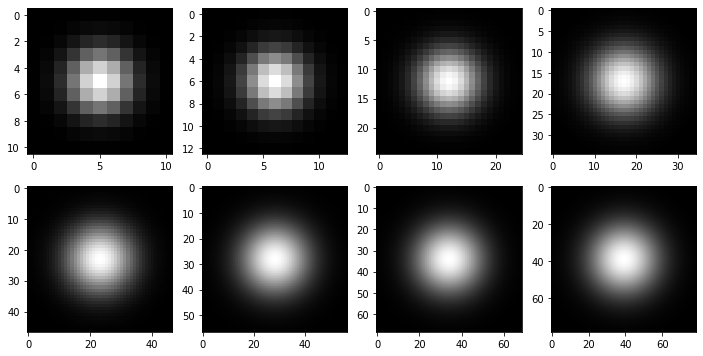

In [4]:
s = 5
sigma = 1.6
# gauss_octave = generate_octave(gaussian_filter(sigma), s, sigma)
gauss_octave = [gaussian_filter(sigma)]
k = 2**(1/5)
for i in range(s+2):
  gauss_octave.append(gaussian_filter(k*(i+1)*sigma))

draw_octave(gauss_octave)

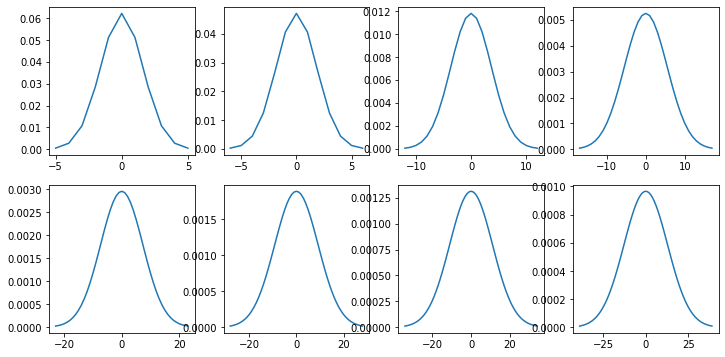

In [5]:
draw_octave1D(gauss_octave)

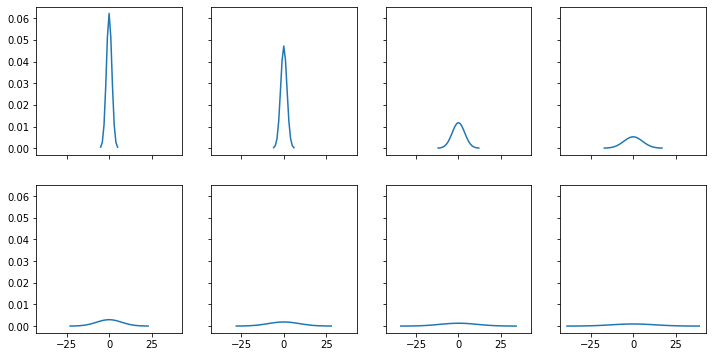

In [6]:
draw_octave1D(gauss_octave, True, True)

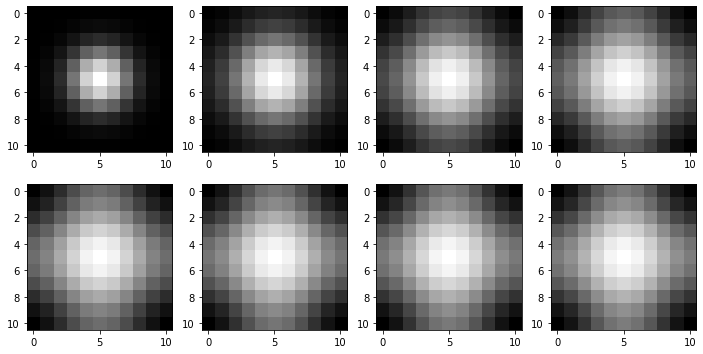

In [7]:
gauss_octave = generate_octave(gaussian_filter(sigma), s, sigma)
draw_octave(gauss_octave)

In [8]:
! git clone https://github.com/soonkijung/cv-datasets

Cloning into 'cv-datasets'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 40 (delta 2), reused 0 (delta 0), pack-reused 37
Unpacking objects: 100% (40/40), done.


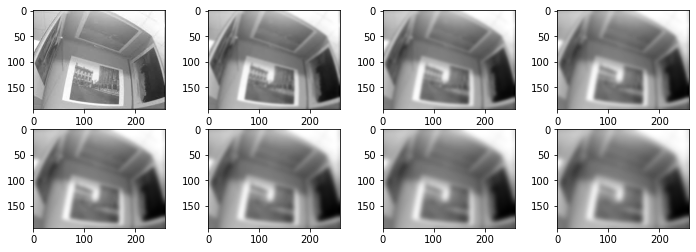

In [9]:
# test for generate_octave
from skimage import color
from skimage import io
image = color.rgb2gray(io.imread('/content/cv-datasets/posters.jpeg'))

octave = generate_octave(image, 5, 1.6) # s = 5, sigma = 1.6

draw_octave(octave)

## 1.6 Generation of Gaussian Pyramid

Just as in the paper, we use an $s$ of 5. One other thing to note is sigma parameter. This parameter is used to scale $k$ so that the blur in each DoG octave goes from $σ → 2 * σ$. I use a value of 1.6 for $σ$. Then to generate the whole Gaussian pyramid:

In [10]:
def generate_gaussian_pyramid(im, num_octave, s, sigma):
  pyr = []
  for _ in range(num_octave):
    octave = generate_octave(im, s, sigma)
    pyr.append(octave)
    im = octave[-3][::2, ::2]
  return pyr

Since we generate $s+3$ images per octave, we use the third to last image as the base for the next octave since that is the one with a blur of 2*sigma.

Now that we have the Gaussian pyramid, it is trivial to create the DoG pyramid:

In [11]:
def generate_DoG_octave(gaussian_octave):
  octave = []

  for i in range(1, len(gaussian_octave)):
    octave.append(gaussian_octave[i] - gaussian_octave[i-1])

  return np.concatenate([o[:, :, np.newaxis] for o in octave], axis=2)

def generate_DoG_pyramid(gaussian_pyramid):
  pyr = []

  for gaussian_octave in gaussian_pyramid:
    pyr.append(generate_DoG_octave(gaussian_octave))

  return pyr

In [12]:
# test for generate_DoG_octave

g_pyr = generate_gaussian_pyramid(image, 4, 5, 1.6) # num_octave = 4, s = 5, sigma = 1.6
dog_pyr = generate_DoG_pyramid(g_pyr)

Gaussian Pyramid
Octave 3


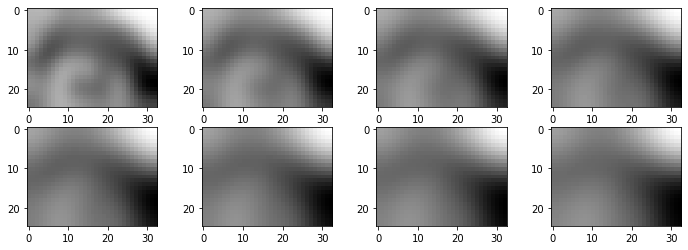

Octave 2


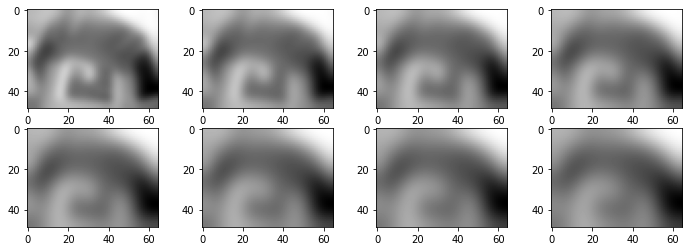

Octave 1


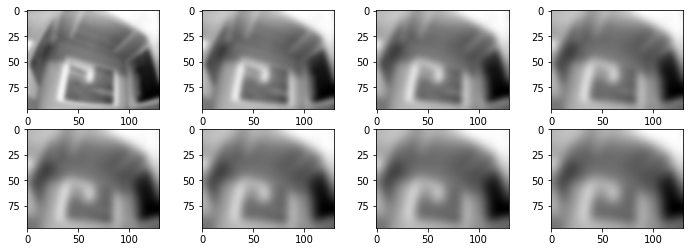

Octave 0


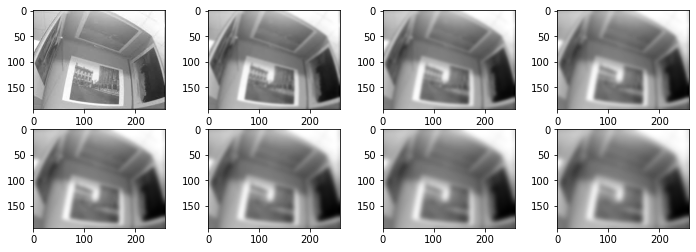

In [13]:
print('Gaussian Pyramid')
for i in range(len(g_pyr)-1, -1, -1):
  print('Octave %d' % (i))
  draw_octave(g_pyr[i])

DoG pyramid
DoG Octave 3


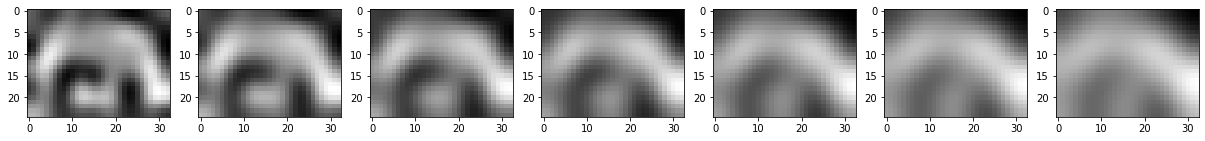

DoG Octave 2


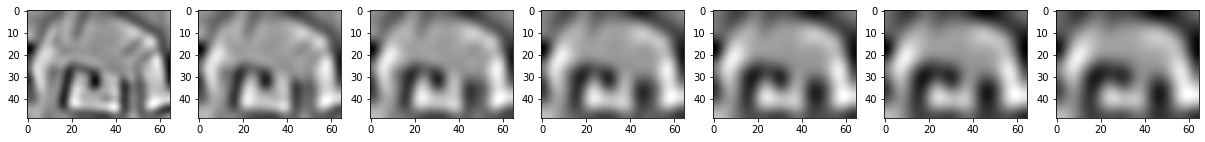

DoG Octave 1


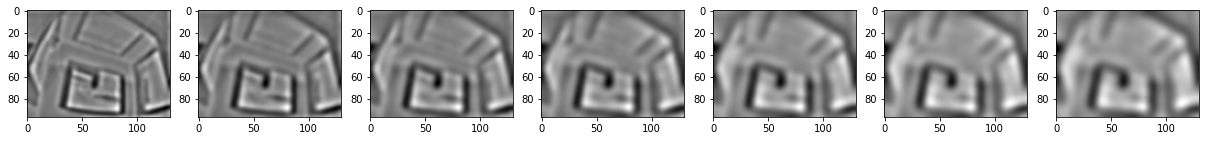

DoG Octave 0


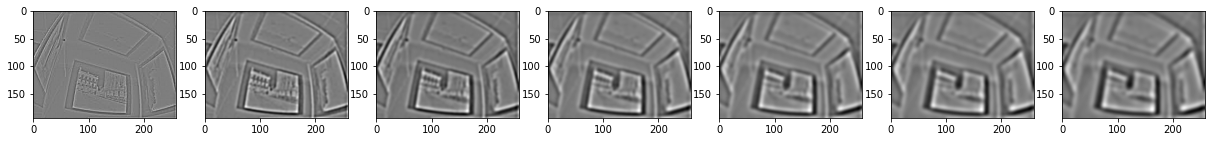

In [14]:
def draw_octaveDoG(octave):
  n = octave.shape[2]
  fig, axs = plt.subplots(1, n, figsize=(3*n, 3))
  for i in range(n):
    axs[i].imshow(octave[:, :, i], cmap='gray')
  plt.show()

print('DoG pyramid')
for i in range(len(dog_pyr)-1, -1, -1):
  print('DoG Octave %d' % (i))
  draw_octaveDoG(dog_pyr[i])

## 1.7 Extrema Detection

The first step in extrema detection is to scan over each scale-space DoG octave, $D$, and include the center of each 3x3x3 neighborhood as a key point if it is the minimum or maximum value in neighborhood.

![alt text](https://miro.medium.com/max/468/1*kwBQSL5U-QGSLd-ovlAHFw.png)

This is why we generated $s+2$ levels in the DoG octave, since we cannot scan over the points in the top or bottom level, but we still want to get keypoints over a full octave of blur.

In [15]:
def get_candidate_keypoints(D, w=16):
  candidates = []
  D[:, :, 0] = 0
  D[:, :, -1] = 0
  for i in range(w//2+1, D.shape[0]-w//2-1):
    for j in range(w//2+1, D.shape[1]-w//2-1):
      for k in range(1, D.shape[2]-1):
        patch = D[i-1:i+2, j-1:j+2, k-1:k+2]
        if np.argmax(patch) == 13 or np.argmin(patch) == 13:
          candidates.append([i, j, k])
  return candidates

Mr.Sam Lerner has a few things to say about this code:

1. He set the top and bottom extra levels to 0 because he was initially only getting extrema in those levels. This is probably due an incorrect construction of the DoG octave, but it seems to work well enough.
2. Instead of scanning with a padding of one on each level, we have a padding of $w/2$ where $w$ is the side length for the patches used when creating local descriptors. Without this, I was getting out of bounds errors.
3. Calling `argmax` or `argmin` Without an axis parameter runs on the flattened array. Since our neighborhood is 3x3x3, or 27 elements long, when the extrema is our inspectecd pixel, the value of argmax or argmin will be 13.

These candidate keypints yield many poor choices and/or noisy, so in the next section we will throw out bad ones as well refine good ones.

In [16]:
# this function will be updated later
def find_keypoints_for_DoG_octave(D, w):
  candidates = get_candidate_keypoints(D, w)
  keypoints = []

  for i, cand in enumerate(candidates):
    y, x, s = cand[0], cand[1], cand[2]

    kp = np.array([x, y, s])
    keypoints.append(kp)

  return np.array(keypoints)

In [17]:
def get_keypoints(DoG_pyr, w):
  kps = []

  for D in DoG_pyr:
    kps.append(find_keypoints_for_DoG_octave(D, w))
  return kps

In [18]:
# for testing get_keypoints
from skimage import color
from skimage import io

gimage = color.rgb2gray(io.imread('/content/cv-datasets/Notre_Dame_1.jpg'))
kernel = gaussian_filter(1.3)
gray_image = convolve(gimage, kernel)
g_pyramid = generate_gaussian_pyramid(gray_image, num_octave=4, s=5, sigma=1.6)
dog_pyramid = generate_DoG_pyramid(g_pyramid)
kps = get_keypoints(dog_pyramid, 16) # w = 16

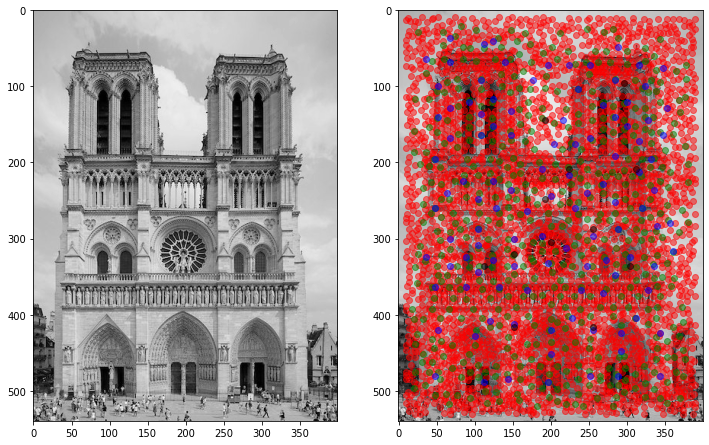

In [19]:
def myDrawKeypoints(image, kps):
  fig, axs = plt.subplots(1, 2, figsize=(12, 8))
  axs[0].imshow(image, cmap='gray')
  axs[1].imshow(image, cmap='gray')
  h = image.shape[0]
  colors = ['red', 'green', 'blue', 'black']
  for o in range(len(kps)):
    if len(kps[o]) == 0: continue
    kpso = kps[o]*(2**o)
    for pt in kpso:
      axs[1].scatter(pt[0], pt[1], color=colors[o], alpha=0.5)

myDrawKeypoints(gimage, kps)

# Keypoint Localization

We will perform three steps to get better keypoints:
1. Compute the subpixel location of each keypoint
2. Throw out that keypoint if it's scale-space value at the subpixel is below a threshold
3. Eliminate keypoints on edges using the Hessian around each subpixel keypoint

## 2.1 Subpixel Localization

In many images, the resolution is not fine enough to find stable keypoints, i.e. in the same location in multiple images under multiple conditions. Therefore, the creators of SIFT use the second-order Taylor expansion of the DoG octave to further localize each keypoint.

\begin{equation}
{\displaystyle D({\textbf {x}})=D+{\frac {\partial D}{\partial {\textbf {x}}}}^{T}{\textbf {x}}+{\frac {1}{2}}{\textbf {x}}^{T}{\frac {\partial ^{2}D}{\partial {\textbf {x}}^{2}}}{\textbf {x}}}
\end{equation}

Here, $x$ is the three-dimensional vector [x, y, σ] corresponding to the pixel location of the candidate keypoint. Taking the derivative of this equation with respect to x and setting it equal to zero yields the subpixel offset for the keypoint:

\begin{equation}
{\displaystyle {\hat {\textbf {x}}}} = {\frac {\partial ^{2}D}{\partial {\textbf {x}}^{2}}}^{-1}{\frac {\partial D}{\partial {\textbf {x}}}}
\end{equation}

This offset is added to the original keypoint location to achieve subpixel accuracy.

In [20]:
import numpy.linalg as LA

def localize_keypoint(D, x, y, s):
  dx = (D[y, x+1, s]-D[y, x-1, s])/2.0
  dy = (D[y+1, x, s]-D[y-1, x, s])/2.0
  ds = (D[y, x, s+1]-D[y, x, s-1])/2.0

  dxx = D[y, x+1, s]-2*D[y, x, s]+D[y, x-1, s]
  dxy = ((D[y+1, x+1, s]-D[y+1, x-1, s]) - (D[y-1, x+1, s]-D[y-1, x-1, s]))/4.0
  dxs = ((D[y, x+1, s+1]-D[y, x-1, s+1]) - (D[y, x+1, s-1]-D[y, x-1, s-1]))/4.0
  dyy = D[y+1, x, s]-2*D[y, x, s]+D[y-1, x, s]
  dys = ((D[y+1, x, s+1]-D[y-1, x, s+1]) - (D[y+1, x, s-1]-D[y-1, x, s-1]))/4.0
  dss = D[y, x, s+1]-2*D[y, x, s]+D[y, x, s-1]

  J = np.array([dx, dy, ds])
  HD = np.array([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])

  offset = -LA.inv(HD).dot(J)
  return offset, J, HD[:2, :2], x, y, s

## 2.2 Discarding Low-Contrast Keypoints

The constrast for each subpixel keypoint can now be computed as:

\begin{equation}
D({\displaystyle {\hat {\textbf {x}}}}) = D + {\frac {1}{2}}{\frac {\partial D}{\partial {\textbf {x}}}}^{T}{\displaystyle {\hat {\textbf {x}}}}
\end{equation}

## 2.3 Eliminating Edge Responses

The scale-normalized LoG will create high-contrast responses on both corners as well as edges. However, keypoints on edges should be discarded because their orientation is ambiguous. To do this, we use the Hessian calculated when computing the subpixel offset. This process is very similar to finding corners using a Harris corner detector.

The Hessian that we return from `localize_keypoint` is of the form:

\begin{equation}
{\textbf  {H}}={\begin{bmatrix}D_{{xx}}&D_{{xy}}\\D_{{xy}}&D_{{yy}}\end{bmatrix}}
\end{equation}

If you are familiar with the Harris detector, if the eigenvalues of $H$(say $λ_1$ and $λ_2$) are both large, then the keypoint is most likely a corner. Conversely, if one is substantially larger, then it is most likely an edge.

Even though it is inexpensive to calculate the eigenvalues for this matrix, there is another way to do it involving takingthe trace and determinant of $H$.

In [21]:
def find_keypoints_for_DoG_octave(D, R_th, t_c, w):
  candidates = get_candidate_keypoints(D, w)
  keypoints = []

  for i, cand in enumerate(candidates):
    y, x, s = cand[0], cand[1], cand[2]
    offset, J, H, x, y, s = localize_keypoint(D, x, y, s)

    contrast = D[y, x, s] + .5*J.dot(offset)
    if abs(contrast) < t_c: continue

    w, v = LA.eig(H)
    r = w[1]/w[0]
    R = (r+1)**2 / r
    if R > R_th: continue

    kp = np.array([x, y, s]) + offset
    keypoints.append(kp)

  return np.array(keypoints)


He uses the values from the paper for t_c and R_th, namely 0.03 and $(10+1)^2/10$, respectively.

Now it is trivial to calculate the keypoints for the whole DoG pyramid:

In [22]:
def get_keypoints(DoG_pyr, R_th, t_c, w):
  kps = []

  for D in DoG_pyr:
    kps.append(find_keypoints_for_DoG_octave(D, R_th, t_c, w))

  return kps

In [23]:
# for testing get_keypoints
from skimage import color
from skimage import io

gimage = color.rgb2gray(io.imread('/content/cv-datasets/Notre_Dame_1.jpg'))
kernel = gaussian_filter(1.3)
gary_image = convolve(gimage, kernel)
g_pyramid = generate_gaussian_pyramid(gray_image, num_octave=4, s=5, sigma=1.6)
dog_pyramid = generate_DoG_pyramid(g_pyramid)
kps = get_keypoints(dog_pyramid, (10+1)**2/10.0, 0.03, 16) # w = 16

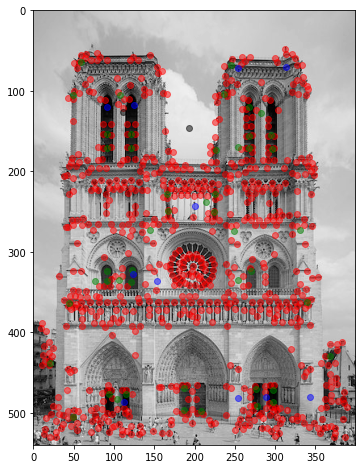

In [24]:
def myDrawKeypoints(image, kps):
  fig, axs = plt.subplots(1, 1, figsize=(12, 8))
  axs.imshow(image, cmap='gray')
  h = image.shape[0]
  colors = ['red', 'green', 'blue', 'black']
  for o in range(len(kps)):
    if len(kps[o]) == 0: continue
    kpso = kps[o]*(2**o)
    for pt in kpso:
      axs.scatter(pt[0], pt[1], color=colors[o], alpha=0.5)
  
myDrawKeypoints(gimage, kps)

## 2.4 Orientation Assignment

Now we have to obtain the actual descriptors. But before we do so, we need to encure another type of invariance: rotational.

We have translational invariance beacuse we convolve our filters over the image. We also have scale invarinace because of our use of the scale-normalized LoG filter. Now to impose rotational invariance, we assign the patch around each keypoint an orientationi corresponding to its dominant gradient direction. This comes in handy later when we use the Histogram of Gradients descriptor to describe each path.

To assign orientation, we take a patch around each keypoint whose size is proportional to the scale of that keypoint. We then create a histogram of the gradients for each pixel in that patch.

The histogram is created on angle (the gradient is specified in polar coordinates) and has 36 bins (each bin has a width of 10 degrees). When the magnitude and angle of the gradient at a pixel is calculated, the corresponding bin in our histogram grows by the gradient magnitude weighted by the Gaussian window.

Once we have our histogram, we assign that keypoint the orientation of the maximal histogram bin.

In [25]:
def assign_orientation(kps, octave, num_bins=36):
  new_kps = []
  bin_width = 360//num_bins

  for kp in kps:
    cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
    s = np.clip(s, 0, octave.shape[2]-1)
    sigma = kp[2]*1.5
    w = int(2*np.ceil(sigma)+1)
    kernel = gaussian_filter(sigma)
    L = octave[..., s]
    hist = np.zeros(num_bins, dtype=np.float32)

    for oy in range(-w, w+1):
      for ox in range(-w, w+1):
        x, y = cx+ox, cy+oy
        if x < 0 or x > octave.shape[1]-1: continue
        elif y < 0 or y > octave.shape[0]-1: continue

        m, theta = get_grad(L, x, y)
        weight = kernel[oy+w, ox+w] * m
        bin = quantize_orientation(theta, num_bins)
        hist[bin] += weight

        max_bin = np.argmax(hist)
        new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, max_bin, bin_width)])
        max_val = np.max(hist)

        for binno, val in enumerate(hist):
          if binno == max_bin: continue
          if .8 * max_val <= val:
            new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, binno, bin_width)])

  return np.array(new_kps)

The one thing I want to mention about this function is the last loop. The paper specifies that for any histogram bin that has a value within 80% of the maximum value to create a new keypoint at that location and scale but with the new orientation.

The paper also says that you should fit a proabola to the three histogram values closest to the maximum, which is done in the following function

In [26]:
def fit_parabola(hist, binno, bin_width):
  centerval = binno*bin_width + bin_width/2.

  if binno == len(hist)-1: rightval = 360 + bin_width/2.
  else: rightval = (binno+1)*bin_width + bin_width/2.

  if binno == 0: leftval = -bin_width/2.
  else: leftval = (binno-1)*bin_width + bin_width/2.

  A = np.array([
                [centerval**2, centerval, 1],
                [rightval**2, rightval, 1],
                [leftval**2, leftval, 1]
  ])
  b = np.array([
                hist[binno],
                hist[(binno+1)%len(hist)],
                hist[(binno-1)%len(hist)]
  ])
  x = LA.lstsq(A, b, rcond=None)[0]
  if x[0] == 0: x[0] = 1e-6
  return -x[1]/(2*x[0])

We simply get the least squares solution  where the center of the max histogram bin as well as its two adjacent bins are taken as the independent variable and the value at that histogram the dependent variable. Once the coefficients for the parabola have been found, just use $-b/2a$ to get the refined orientation.

There are also a few functions not included in this code. First is `get_grads`, which gets the gradientg in polar coordinates at a pixel in $L$:

In [27]:
def cart_to_polar_grad(dx, dy):
  m = np.sqrt(dx**2 + dy**2)
  theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi
  return m, theta

def get_grad(L, x, y):
  dy = L[min(L.shape[0]-1, y+1), x] - L[max(0, y-1), x]
  dx = L[y, min(L.shape[1]-1, x+1)] - L[y, max(0, x-1)]
  return cart_to_polar_grad(dx, dy)

Then there is `quantize_orientation`, which simply converts the continuous angle of the gradient to a histogram bin:

In [28]:
def quantize_orientation(theta, num_bins):
  bin_width = 360//num_bins
  return int(np.floor(theta)//bin_width)

## 2.5 Local Descriptor Creation

Finally, we can create the local descriptors for each keypoint. As previously mentioned, we use the Histogram of Gradients method to create a feature vector from the surroundings of each keypoint.

Specifically, a 16x16 patch is inspected around each keypoint. That patch is then split up into 16 4x4 subregions. The gradients (in polar coordinates) of each subregion are then binned into an 8-bin histogram. Finally, all of these histograms are concatenated into a 4x4x8=128 element long feature vector.

This final feature vector is then normalized, thresholded, and renormalized to try and ensure invariance to minor lighting changes.

In [29]:
def get_local_descriptors(kps, octave, w=16, num_subregion=4, num_bin=8):
  descs = []
  bin_width = 360//num_bin

  for kp in kps:
    cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
    s = np.clip(s, 0, octave.shape[2]-1)
    kernel = gaussian_filter(w/6) # gaussian_filter multiplies sigma by 3
    L = octave[..., s]

    t, l = max(0, cy-w//2), max(0, cx-w//2)
    b, r = min(L.shape[0], cy+w//2+1), min(L.shape[1], cx+w//2+1)
    patch = L[t:b, l:r]
    dx, dy = get_patch_grads(patch)

    if dx.shape[0] < w+1:
      if t == 0: kernel = kernel[kernel.shape[0]-dx.shape[0]:]
      else: kernel = kernel[:dx.shape[0]]
    if dx.shape[1] < w+1:
      if l == 0: kernel = kernel[kernel.shape[1]-dx.shape[1]:]
      else: kernel = kernel[:dx.shape[1]]
    if dy.shape[0] < w+1:
      if t == 0: kernel = kernel[kernel.shape[0]-dy.shape[0]:]
      else: kernel = kernel[:dy.shape[0]]
    if dy.shape[1] < w+1:
      if l == 0: kernel = kernel[kernel.shape[1]-dy.shape[1]:]
      else: kernel = kernel[:dy.shape[1]]

    m, theta = cart_to_polar_grad(dx, dy)
    dx, dy = dx*kernel, dy*kernel

    subregion_w = w//num_subregion
    featvec = np.zeros(num_bin * num_subregion**2, dtype=np.float32)

    for i in range(0, num_subregion):
      for j in range(0, num_subregion):
        t, l = i*subregion_w, j*subregion_w
        b = min(m.shape[0], (i+1)*subregion_w)
        r = min(m.shape[1], (j+1)*subregion_w)

        hist = get_histogram_for_subregion(m[t:b, l:r].ravel(),
                                           theta[t:b, l:r].ravel(), num_bin, kp[3], bin_width, subregion_w)
        
        featvec[i*subregion_w*num_bin + j*num_bin
                :i*subregion_w*num_bin + (j+1)*num_bin] = hist.flatten()

    featvec /= max(1e-6, LA.norm(featvec))
    featvec[featvec>0.2] = 0.2
    featvec /= max(1e-6, LA.norm(featvec))
    descs.append(featvec)

  return np.array(descs)

The checks on the shape of `dx` and `dy` in the middle are to avoid out of bounds errors I was getting earlier. If either/or are smaller than `w+1` then cut off the Gaussian window accordingly to avoid shape mismatches.

First, the polar gradients are computed for the whole patch. Then the histogram is created for each subregion. Once the histogram for each subregion has been concatenated, the entire feature vector is normalized, thresholded to be less than or equal to 0.2, and then renormalized.

I'm not 100% certain on the motivation behind the thresholding and renormalizetion but I believe it helps provide invariance to nonlinear lighting changes.

To calculate the gradients across the patch:

In [30]:
def get_patch_grads(p):
  r1 = np.zeros_like(p)
  r1[-1] = p[-1]
  r1[:-1] = p[1:]

  r2 = np.zeros_like(p)
  r2[0] = p[0]
  r2[1:] = p[:-1]

  dy = r1-r2

  r1[:,-1] = p[:,-1]
  r1[:,:-1] = p[:,1:]
  r2[:,0] = p[:,0]
  r2[:,1:] = p[:,:-1]

  dx = r1-r2

  return dx, dy

Just take the difference between the previous and current pixels. This is easier than doing the double-sided derivative as before.

Then to create the histogram for each subregion:

In [31]:
def get_histogram_for_subregion(m, theta, num_bin, reference_angle, bin_width, subregion_w):
  hist = np.zeros(num_bin, dtype=np.float32)
  c = subregion_w/2 - .5

  # for mag, angle in zip(m, theta):
  for i, (mag, angle) in enumerate(zip(m, theta)):
    angle = (angle-reference_angle) % 360
    binno = quantize_orientation(angle, num_bin)
    vote = mag

    hist_interp_weight = 1 - abs(angle - (binno*bin_width + bin_width/2))/(bin_width/2)
    vote *= max(hist_interp_weight, 1e-6)

    gy, gx = np.unravel_index(i, (subregion_w, subregion_w))
    x_interp_weight = max(1 - abs(gx - c)/c, 1e-6)
    y_interp_weight = max(1 - abs(gy - c)/c, 1e-6)
    vote *= x_interp_weight * y_interp_weight

    hist[binno] += vote

  hist /= max(1e-6, LA.norm(hist))
  hist[hist>0.2] = 0.2
  hist /= max(1e-6, LA.norm(hist))

  return hist

The code is fairly similar to the previous HoG code however we perform trilinear interpolation on each entry into the histogram.

The interpolation is to provide robustness for when a gradient at a pixel either goes from one bin to the other or is at the edge of a subregion and goes into a different subregion.

Therefore, the weight of an entry is proportional to 1-(distance from the center of the bin) and well as 1-(distance from the center of the subregion) for both the x and y directions. The spatial (x and y) interpolation is the only thing I am not sure about because I could not find a reliable source on it.

In [32]:
from skimage.color import rgb2gray

class SIFT(object):
  def __init__(self, im, s=3, num_octave=4, s0=1.3, sigma=1.6, r_th=10, t_c=0.03, w=16):
    self.im = convolve(rgb2gray(im), gaussian_filter(s0))
    self.s = s
    self.sigma = sigma
    self.num_octave = num_octave
    self.t_c = t_c
    self.R_th = (r_th+1)**2 / r_th
    self.w = w

  def get_features(self):
    gaussian_pyr = generate_gaussian_pyramid(self.im, self.num_octave, self.s, self.sigma)
    DoG_pyr = generate_DoG_pyramid(gaussian_pyr)
    kp_pyr = get_keypoints(DoG_pyr, self.R_th, self.t_c, self.w)
    feats = []

    for i, DoG_octave in enumerate(DoG_pyr):
      print(i) # check iteral
      kp_pyr[i] = assign_orientation(kp_pyr[i], DoG_octave)
      feats.append(get_local_descriptors(kp_pyr[i], DoG_octave))

    self.kp_pyr = kp_pyr
    self.feats = feats

    return feats

# Feature Matching

In [33]:
from skimage import color
from skimage import io

def get_features(fnames):
  ims = []

  kp_feats = []
  kp_ptrs = []

  for i, fname in enumerate(fnames):
    im = io.imread(fname)
    ims.append(im)
    gray_image = color.rgb2gray(im)

    sift_detector = SIFT(gray_image)
    _ = sift_detector.get_features()
    feats = sift_detector.feats
    pyrs = sift_detector.kp_pyr

    for oct_i, oct_v in enumerate(pyrs):
      kps = oct_v*(2**oct_i)

      if oct_i == 0:
        featsAcc = feats[oct_i]
        ptrsAcc = kps
      else:
        featsAcc = np.vstack((featsAcc, feats[oct_i]))
        ptrsAcc = np.vstack((ptrsAcc, kps))

    kp_feats.append(featsAcc)
    kp_ptrs.append(ptrsAcc)
  
  return ims, kp_ptrs, kp_feats

def get_matches(feats1, feats2, ratio=0.8):
  idxs1, idxs2 = [], []
  for i, feat in enumerate(feats1):
    distances = LA.norm(feats2-feat, axis=1)
    nn = np.argsort(distances)[:2]
    dist1, dist2 = distances[nn[0]], distances[nn[1]]

    if dist1/max(1e-6, dist2) < ratio:
      idxs1.append(i)
      idxs2.append(nn[0])

  return idxs1, idxs2

In [34]:
fnames = ['/content/cv-datasets/Notre_Dame_1.jpg', '/content/cv-datasets/Notre_Dame_2.jpg']

ims, kp_ptrs, kp_feats = get_features(fnames)
idxs1, idxs2 = get_matches(kp_feats[0], kp_feats[1])

<ipython-input-32-bb9ac0bef40f>:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.im = convolve(rgb2gray(im), gaussian_filter(s0))


0
1
2
3
0
1
2
3


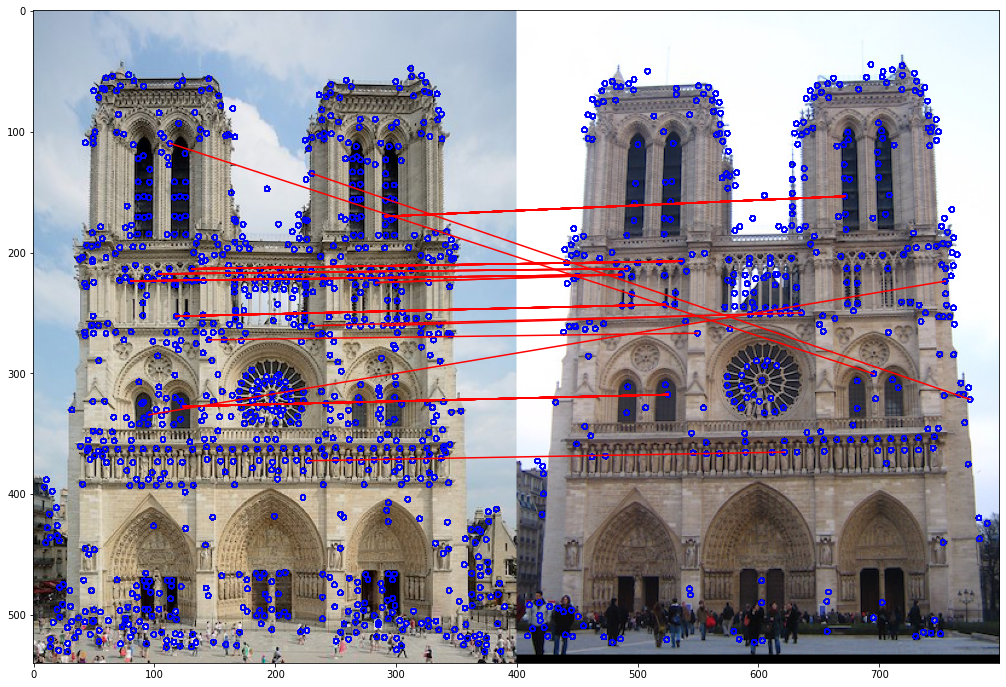

In [35]:
row1, col1 = ims[0].shape[:2]
row2, col2 = ims[1].shape[:2]

stackedImage = np.zeros((max(row1, row2), col1 + col2, ims[0].shape[2]),
                        dtype=ims[0][0, 0, 0].dtype)
stackedImage[:row1, :col1, :] = ims[0]
stackedImage[:row2, col1:col1+col2, :] = ims[1]

_, ax = plt.subplots(1, 1, figsize=(18, 12))
ax.imshow(stackedImage)

ax.scatter(kp_ptrs[0][:,0], kp_ptrs[0][:,1], s=25, facecolors='none',
           edgecolors='b', alpha=0.8)
ax.scatter(kp_ptrs[1][:,0] + col1, kp_ptrs[1][:,1], s=25, facecolors='none',
           edgecolors='b', alpha=0.8)

for i in range(len(idxs1)):
  kps1 = kp_ptrs[0][idxs1[i]]
  kps2 = kp_ptrs[1][idxs2[i]]
  x1, y1 = (kps1[0], kps1[1])
  x2, y2 = (kps2[0]+col1, kps2[1])
  ax.plot([x1, x2], [y1, y2], c='r')

plt.show()